# Create elevation model on the same grid as satellite tile

The imagery data of Sentinel-2 is based upon a staggered pushbroom sensor. It therefor collects imagery with an perspective view. However, the data is provided as a mapview. This data transformation is done via an elevation model, that orthorectifies the imagery into such a product. Luckily, the elevation model that is used for this procedure is available, it is called CopernicusDEM. In the following an example is shown that downloads and merges this elevation model to the same extent and resolution as an Sentinel-2 tile.

Before starting it is important to create an account on [Copernicus Spacedata](https://spacedata.copernicus.eu/cop-dem-faq), otherwise it is not possible to do any downloading.

### import of functions from libraries
First we need to import some generic libraries for plotting and file manipulation

In [1]:
import matplotlib.pyplot as plt

import os
import numpy as np

Than more specific functions can be imported from the **dhdt** library

In [2]:
from dhdt.auxilary.handler_cop import \
    get_copDEM_s2_tile_intersect_list, download_and_mosaic_through_ftps, \
    get_cds_path_copDEM, get_cds_url

from dhdt.generic.mapping_tools import get_bbox
from dhdt.generic.mapping_io import make_im_from_geojson, read_geo_image
from dhdt.generic.handler_sentinel2 import get_generic_s2_raster, \
    get_s2_image_locations, get_s2_dict

from dhdt.input.read_sentinel2 import list_central_wavelength_msi

from dhdt.postprocessing.solar_tools import make_shading

### data preparation

A local file directory is given here, hence use your own file path.

In [3]:
dat_dir = '/local/path/S2A_MSIL1C_20201019T213531_N0209_R086_T05VMG_20201019T220042.SAFE'
sso = 'give-username'
pw = 'provide-pass-word'

Here we take the high resolution (10 meter) data of Sentinel-2.

In [4]:
boi = ['red', 'green', 'blue', 'nir']
s2_df = list_central_wavelength_msi()
s2_df = s2_df[s2_df['common_name'].isin(boi)]
s2_df, datastrip_id = get_s2_image_locations(os.path.join(dat_dir, 'MTD_MSIL1C.xml'), s2_df)
s2_dict = get_s2_dict(s2_df)
toi = s2_dict['tile_code'] # tile of interest

In [5]:
dem_path = '/local/path/Cop-DEM_GLO-30/'
dem_name = 'COP-DEM-'+toi+'.tif'

The CopernicusDEM is an aggregation of satellite and aerial mapping products. The main dataset is based on the Tandem-X digital elevation model, that used interferometric SAR. But infilling via other datasources, and manual editting is also applied to this dataset.

Anyways, the tiling system of this dataset is different from Sentinel-2, thus tiles of CopernicusDEM that overlap need to be found.

In [6]:
urls,tars = get_copDEM_s2_tile_intersect_list(toi)

geoTransform, crs = get_generic_s2_raster(toi)

Lets see if the correct projection parameters are extracted

In [7]:
crs.ExportToWkt()

'PROJCS["WGS 84 / UTM zone 5N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-153],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32605"]]'

Now the downloading of the tiles can be done.

In [9]:
bbox = get_bbox(geoTransform)
bbox = bbox.reshape((2, 2)).T.ravel()  # x_min, y_min, x_max, y_max

cds_path, cds_url = get_cds_path_copDEM(), get_cds_url()
cop_dem = download_and_mosaic_through_ftps(tars, dem_path,
                                           cds_url, cds_path[4:],
                                           sso, pw, bbox, crs, geoTransform)
cop_dem.rio.write_nodata(-9999, encoded=True, inplace=True)
cop_dem.rio.to_raster(os.path.join(dem_path,dem_name))

Great you use CopernicusDEM, if you do use this data for products, publications, repositories, etcetera. 
Please make sure you cite via the following doi: https://doi.org/10.5270/ESA-c5d3d65


/Users/Alten005/anaconda3/envs/eratosthenes/lib/python3.8/site-packages/rioxarray/raster_writer.py:115: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/Alten005/anaconda3/envs/eratosthenes/lib/python3.8/site-packages/rioxarray/raster_writer.py:115: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/Alten005/anaconda3/envs/eratosthenes/lib/python3.8/site-packages/rioxarray/raster_writer.py:115: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/Users/Alten005/anaconda3/envs/eratosthenes/lib/python3.8/site-packages/rioxarray/raster_writer.py:115: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match 

Now the data is on your local machine and in the correct shape, now this can be loaded.

In [10]:
f_full = os.path.join(dem_path,dem_name)

Z = read_geo_image(f_full)[0]

Finally, the data can be plotted, but only a subset, so details can still be seen.

In [11]:
h,w = 2000, 5000
m,n = Z.shape[0], Z.shape[1]
j_min, i_min = np.random.randint(w, n-w), np.random.randint(h, m-h)
j_max, i_max = j_min + w, i_min + h

In [12]:
Shd = make_shading(Z[i_min:i_max,j_min:j_max], 45, 60)

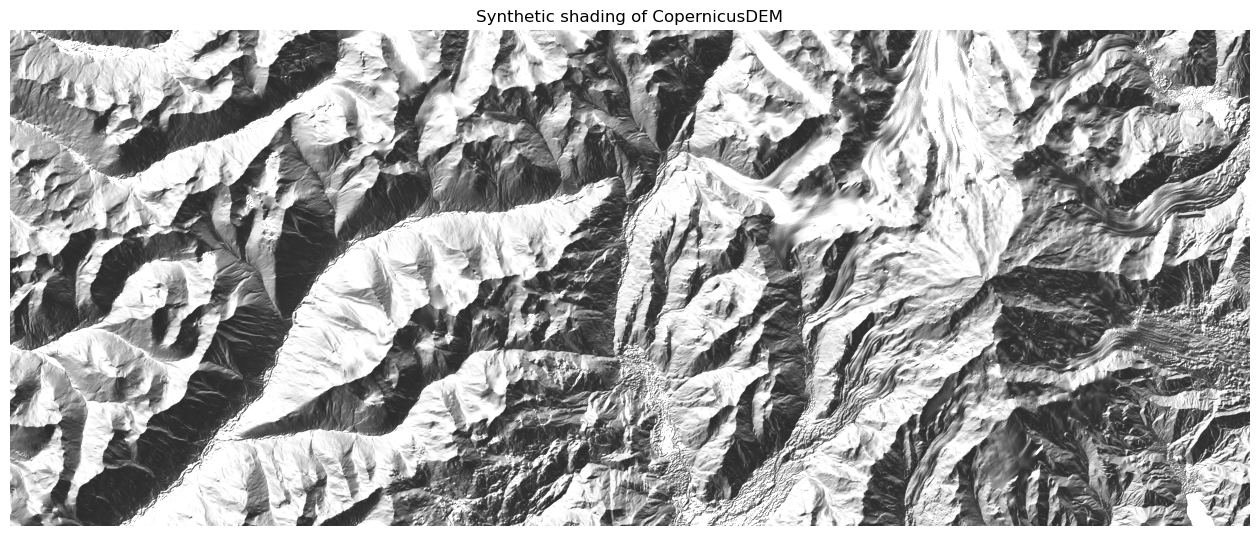

In [13]:
plt.rcParams['figure.figsize'] = [16.,8.]
plt.title('Synthetic shading of CopernicusDEM'),
plt.imshow(Shd, cmap=plt.cm.gray, vmin=-0.7, vmax=+.5), plt.axis('off');